In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from scipy import stats
from tqdm import tqdm

# Introduction

In this notebook, I do some analysis - mostly brief, exploratory analysis - of my liked songs on Spotify. This project is purely driven by personal interest, with no pretensions of practical use. I like music as much as the next person, so when I learned that Spotify attempted to quantify various characteristics of music and automatically detect others, I became interested in what I could learn about my own taste, other than I like songs that are mostly metal, some mixture between corny and aggressive, and loud. To do this, I performed a clustering analysis.

In [2]:
df = pd.read_csv('liked_songs.csv', index_col=0)
print(f'There are {len(df)} rows in the dataframe.')
df.head()

There are 1336 rows in the dataframe.


id                                         track_name  \
0  2mkIuDdISUvCcrxxZ4EN6b                                  Edge of the Night   
1  0DDUNKcxiNVf7mMhGovPT0                                       Kronian Moon   
2  4oTLgIDkeBPB4YjHRGJ6EI                                      Glitch Cannon   
3  2Pvxvrbl8J6YFl5vSJzEDp                                      Discipline 27   
4  0BUxtt8OufQRdqpcu2uaXU  The Lady with the Golden Stockings (The Golden...   

             artist                  album_name album_release_date  \
0              Nite  Voices of the Kronian Moon         2022-03-25   
1              Nite  Voices of the Kronian Moon         2022-03-25   
2  Artificial Brain            Artificial Brain         2022-06-03   
3              EABS        Discipline of Sun Ra         2020-10-30   
4              EABS        Discipline of Sun Ra         2020-10-30   

   album_track_num  album_track_placement  genre  duration_ms  explicit  ...  \
0                6               0.750000    NaN     5.057467     False  ...   
1                2               0.250000    NaN     3.989900     False  ...   
2                2               0.200000    NaN     3.635300     False  ...   
3                4               0.571429    NaN     5.344567     False  ...   
4                3               0.428571    NaN     3.306467     False  ...   

   key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    9    -5.673     0       0.1450      0.000010             0.777     0.122   
1    2    -4.680     0       0.0578      0.000018             0.516     0.106   
2    5    -9.562     0       0.0614      0.000124             0.945     0.436   
3   10    -8.203     0       0.0501      0.043400             0.336     0.278   
4   11    -9.357     0       0.0564      0.193000             0.944     0.118   

   valence    tempo  time_signature  
0   0.1700  144.036               4  
1   0.1670  123.982               4  
2   0.0363   95.020               4  
3   0.2050   90.492               4  
4   0.1850  117.210               3  

[5 rows x 23 columns]

# Data Cleaning

## Checking the Genre Feature
According to Spotify's API documentation, when looking up track info, the response should either contain an array of genres for the tracks artist, which should be empty if no genres are assigned. This does not seem to actually be the case at least for every artist, and when running a few google searches, I found people who had similar issues over the past several years. I wrote my code to save genre information to a csv if present and enter a NaN value otherwise. Here, I check to see if there was any genre information. If there is not, I drop the feature.

In [3]:
df['genre'].unique()[0]

nan

In [4]:
if len(df['genre'].unique()) == 1:
    genre_val = df['genre'].unique()[0]
    print(f'The genre field contains only the following value: {genre_val}.')
    df = df.drop('genre', axis=1)
else:
    print('The genre feature contains non-nan values.')

The genre field contains only the following value: nan.


## Encoding Album Release Dates
Spotify does not always have exact release dates. Sometimes it has release years. For consistency and cleanliness, I will keep only release years for all albums. Values are either in YYYY-MM-DD format or are just the years, so to get years, I split on dashes, and keep only the first entry in the resulting list.

In [5]:
df['album_release_date'] = df['album_release_date'].str.split('-').map(lambda x: int(x[0]))

## Renaming Columns
I rename album_release_date to album_release_year because of the above change. Additionally, I rename duration_ms to duration_min, since the units are minutes.

In [6]:
df = df.rename(columns={'album_release_date':'album_release_year', 'duration_ms':'duration_min'})

# Exploratory Data Analysis
The data consists of numerical, boolean, and other categorical features. The features are the following, with descriptions provided where not obvious. See [here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features) for a full description of the audio features.

* General Categorical
    * track_name
    * artist
    * album_name
* Boolean
    * explicit: True if the song is known to contain explicit lyrics, False otherwise
    * mode: whether the songs is written in a major or minor scale
* Numerical
    * album_track_num: the track number on the album
    * album_track_placement: describes  how far the track is through the album, (album_track_num / total tracks on the album)
    * album_release_year: the year in which the album was released
    * duration_min: the track duration in minutes
    * popularity: artist popularity, ranging from 0  (least popular) to 100 (most popular)
    * danceability: how danceabile a song is based on factors like tempo, rhythm stability, beat strength. Ranges from 0 (least danceable) to 1 (most danceable)
    * energy: how energetic a song sounds. Ranges from 0 (least energetic) to 1 (most energetic)
    * key: the key of the track assuming it falls into a 12 tone system. Takes integers from 1 (C) to 11.
    * loudness: average loudness of the track in decibels
    * speechiness: how much the song sounds like speech. Ranges from 0 (not at all like speech) to 1 (sounds like exclusively speech)
    * acousticness: confidence that the track is acoustic. Ranges from 0 (very low confidence the track is acoustic) to 1 (very high confidence tha track is acoustic)
    * instrumentalness: confidence that the track contains no vocals. Ranges from 0 (very low confidence the track contains no vocals) to 1 (very high confidence the track contains no vocals)
    * liveness: confidence that the track is live. Ranges from 0 (low confidence) to 1 (high confidence)
    * valence: how positive (as in happy, energetic) the song sounds. Ranges from 0 (sad, angry, etc.) to 1 (happy, energetic, etc.)
    * tempo: the speed of the track in beats per minute
    * time_signature: an integer representation of the time signature. Ranges from 3 as in 3/4 to 7 as in 7/4.

In [7]:
numerical = ['album_track_num', 'album_track_placement', 'album_release_year', 'duration_min', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
boolean = ['mode', 'explicit']
categorical = ['artist_name', 'album_name']
song_info = ['track_name', 'artist', 'album_name']
df[numerical].describe()

album_track_num  album_track_placement  album_release_year  \
count      1336.000000            1336.000000         1336.000000   
mean          4.155689               0.433919         2010.854790   
std           2.955300               0.278496            7.549776   
min           1.000000               0.030303         1972.000000   
25%           2.000000               0.200000         2008.000000   
50%           3.000000               0.375000         2013.000000   
75%           6.000000               0.625000         2016.000000   
max          16.000000               1.000000         2022.000000   

       duration_min   popularity  danceability       energy          key  \
count   1336.000000  1336.000000   1336.000000  1336.000000  1336.000000   
mean       6.186966    13.269461      0.337626     0.825712     5.208832   
std        3.615311    15.025945      0.144844     0.199650     3.588865   
min        0.968217     0.000000      0.059300     0.000707     0.000000   
25%        4.203025     0.000000      0.217000     0.762750     2.000000   
50%        5.304775     9.000000      0.336500     0.908000     5.000000   
75%        7.189333    23.000000      0.443250     0.961000     8.000000   
max       57.003767    73.000000      0.903000     0.999000    11.000000   

          loudness  speechiness  acousticness  instrumentalness     liveness  \
count  1336.000000  1336.000000   1336.000000       1336.000000  1336.000000   
mean     -6.565744     0.085956      0.054443          0.435847     0.223005   
std       3.450206     0.060603      0.173401          0.372322     0.166793   
min     -42.238000     0.024900      0.000000          0.000000     0.020400   
25%      -7.747250     0.046100      0.000020          0.012175     0.104000   
50%      -5.793500     0.068800      0.000220          0.460500     0.156000   
75%      -4.532750     0.103000      0.005097          0.816250     0.313250   
max       2.121000     0.798000      0.985000          0.995000     0.970000   

           valence        tempo  time_signature  
count  1336.000000  1336.000000     1336.000000  
mean      0.211099   123.759373        3.815120  
std       0.166339    29.276529        0.540034  
min       0.021500    56.542000        1.000000  
25%       0.079875   102.066500        4.000000  
50%       0.162000   120.035500        4.000000  
75%       0.300000   143.386000        4.000000  
max       0.964000   200.188000        5.000000

In [8]:
for feat in numerical[2:]:
    print(f'________________________{feat.upper()}________________________')
    min_feat_values = df[df[feat] == df[feat].min()][song_info+[feat]].values[0]
    max_feat_values = df[df[feat] == df[feat].max()][song_info+[feat]].values[0]
    print(f'The song with the highest {feat} is {max_feat_values[0]} by {max_feat_values[1]} off of the album {max_feat_values[2]}, with a {feat} value of {max_feat_values[3]}')
    print(f'The song with the lowest {feat} is {min_feat_values[0]} by {min_feat_values[1]} off of the album {min_feat_values[2]}, with a {feat} value of {min_feat_values[3]}\n')

________________________ALBUM_RELEASE_YEAR________________________
The song with the highest album_release_year is Edge of the Night by Nite off of the album Voices of the Kronian Moon, with a album_release_year value of 2022
The song with the lowest album_release_year is Suicide by Dust off of the album Hard Attack/Dust, with a album_release_year value of 1972

________________________DURATION_MIN________________________
The song with the highest duration_min is Monolithe IV by Monolithe off of the album Monolithe IV, with a duration_min value of 57.00376666666667
The song with the lowest duration_min is I Accept Your Last Wish by Gridlink off of the album Orphan, with a duration_min value of 0.9682166666666668

________________________POPULARITY________________________
The song with the highest popularity is C.R.E.A.M. (Cash Rules Everything Around Me) (feat. Method Man, Raekwon, Inspectah Deck & Buddha Monk) by Wu-Tang Clan off of the album Enter The Wu-Tang (36 Chambers) [Expanded 

Most of the above are very sensible, with the exception of a few values that suggest errors on Spotify's end. For brevity, I will only discuss potential errors.

Sepal by Emptyset is purely instrumental, but Spotify is fairly confident it is largely speech. The song seems to largely consist of a recording of a person playing a wind or reed instrument, including the sound of the breath, edited in various ways.

Spotify seems to have struggled with Edeste by Khôrada, finding its modality to be major and its time signature presumably to be 1/4. While my music theory is rusty, the song to be is not so obviously major. Further, Spotify's [documentation](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features) states they give songs time signature values ranging from 3 to 7, corresponding to 3/4, 4/4, 5/4, 6/4 and 7/4, but they gave this song a 1. It is unclear why this is the case. The song is in 6/8, but there are some drony sections that might confuse a computer trying to assign the song a time signature.

I suspect the time_signature identification might be unreliable. In addition to the above, I know I have a song in my liked songs that is 7/4, Foe by the band Leprous, but I have no songs with time_signature = 7. First, I check what time signature that song was assigned.

In [9]:
df[df['track_name'] == 'Foe'][song_info+['time_signature']]

track_name   artist album_name  time_signature
918        Foe  Leprous       Coal               1

Similarly to Edeste, this song has a time_signature value of 1. And the percussion in this [song](https://www.youtube.com/watch?v=D61fSxqBLwc) makes the time signature a bit non-obvious, even to a human listener. This makes me think that maybe time_signature values of 1 are assigned if the time signature is unknown. I peak at the songs with time_signature = 1 to find out more.

In [10]:
time_sig_1 = df[df['time_signature'] == 1]
print(f'There are {len(time_sig_1)} songs with a time_signature value of 1')
time_sig_1[song_info]

There are 23 songs with a time_signature value of 1


track_name                   artist  \
5                                         Edeste                  Khôrada   
136   Into the Vaults of Ingurgitating Obscurity              Chthe'ilist   
171              Shake My Hand, Bow down and Die              Die Choking   
187                                      Motions     Sun Of The Sleepless   
272                      Within the Dead Horizon                   Inferi   
286                 Self Portrait In Ultramarine                Ben Frost   
315                                         Shed                Meshuggah   
321                                   Clockworks                Meshuggah   
326                         Where Mountains Rise                 Immortal   
360        What a Horrible Night to Have a Curse  The Black Dahlia Murder   
483                                The Architect                    Haken   
484                                         1985                    Haken   
627                                  In Memoriam                    Haken   
704                                        Again     Black Crown Initiate   
743                                   Clockworks                Meshuggah   
862                       Body Bags for the Gods                Katalepsy   
918                                          Foe                  Leprous   
928                                The Architect                    Haken   
929                                         1985                    Haken   
959                      And the Vulture Beholds      Fleshgod Apocalypse   
1103                        Closed Gates Of Hope                Catamenia   
1189                           March Of The Pigs          Nine Inch Nails   
1267                                 In Memoriam                    Haken   

                                 album_name  
5                                      Salt  
136                   Le Dernier Crépuscule  
171                                     III  
187                         To the Elements  
272                                Revenant  
286   All That You Love Will Be Eviscerated  
315                      Catch Thirty Three  
321             The Violent Sleep of Reason  
326                     Northern Chaos Gods  
360                               Nocturnal  
483                                Affinity  
484                                Affinity  
627                            The Mountain  
704                Selves We Cannot Forgive  
743             The Violent Sleep of Reason  
862                           Autopsychosis  
918                                    Coal  
928               Affinity (Deluxe Edition)  
929               Affinity (Deluxe Edition)  
959                                    King  
1103                         Location: COLD  
1189                    The Downward Spiral  
1267                           The Mountain

These songs fall into a few categories. Some are straightforward 6/8 metal tracks like Where Mountains Rise. Some have multiple odd (but sometimes perfectly countable) time signatures, like The Architect. Two, the Meshuggah tracks, are arguably in 4/4 but can be hard to follow. And one, Self Portrait in Ultramarine has no discernible time signature. But suppose Spotify labeled any track with those characteristics as having a time signature of 1. I would then expect a lot more songs to receive this label. So many metal songs are in 6/8 it is almost cliche, I would expect many more songs with the label because of odd time signature changes, every Meshuggah song I have liked can be described as "arguably 4/4 but can be hard to follow," and ambient, drone, and most noise usually have no discernible time signature.

Due to the above, the usefulness and reliability of the time_signature feature is questionable.

# Univariate Distributions

In [11]:
df.describe()

album_release_year  album_track_num  album_track_placement  \
count         1336.000000      1336.000000            1336.000000   
mean          2010.854790         4.155689               0.433919   
std              7.549776         2.955300               0.278496   
min           1972.000000         1.000000               0.030303   
25%           2008.000000         2.000000               0.200000   
50%           2013.000000         3.000000               0.375000   
75%           2016.000000         6.000000               0.625000   
max           2022.000000        16.000000               1.000000   

       duration_min   popularity  danceability       energy          key  \
count   1336.000000  1336.000000   1336.000000  1336.000000  1336.000000   
mean       6.186966    13.269461      0.337626     0.825712     5.208832   
std        3.615311    15.025945      0.144844     0.199650     3.588865   
min        0.968217     0.000000      0.059300     0.000707     0.000000   
25%        4.203025     0.000000      0.217000     0.762750     2.000000   
50%        5.304775     9.000000      0.336500     0.908000     5.000000   
75%        7.189333    23.000000      0.443250     0.961000     8.000000   
max       57.003767    73.000000      0.903000     0.999000    11.000000   

          loudness         mode  speechiness  acousticness  instrumentalness  \
count  1336.000000  1336.000000  1336.000000   1336.000000       1336.000000   
mean     -6.565744     0.566617     0.085956      0.054443          0.435847   
std       3.450206     0.495728     0.060603      0.173401          0.372322   
min     -42.238000     0.000000     0.024900      0.000000          0.000000   
25%      -7.747250     0.000000     0.046100      0.000020          0.012175   
50%      -5.793500     1.000000     0.068800      0.000220          0.460500   
75%      -4.532750     1.000000     0.103000      0.005097          0.816250   
max       2.121000     1.000000     0.798000      0.985000          0.995000   

          liveness      valence        tempo  time_signature  
count  1336.000000  1336.000000  1336.000000     1336.000000  
mean      0.223005     0.211099   123.759373        3.815120  
std       0.166793     0.166339    29.276529        0.540034  
min       0.020400     0.021500    56.542000        1.000000  
25%       0.104000     0.079875   102.066500        4.000000  
50%       0.156000     0.162000   120.035500        4.000000  
75%       0.313250     0.300000   143.386000        4.000000  
max       0.970000     0.964000   200.188000        5.000000

## Numerical Features

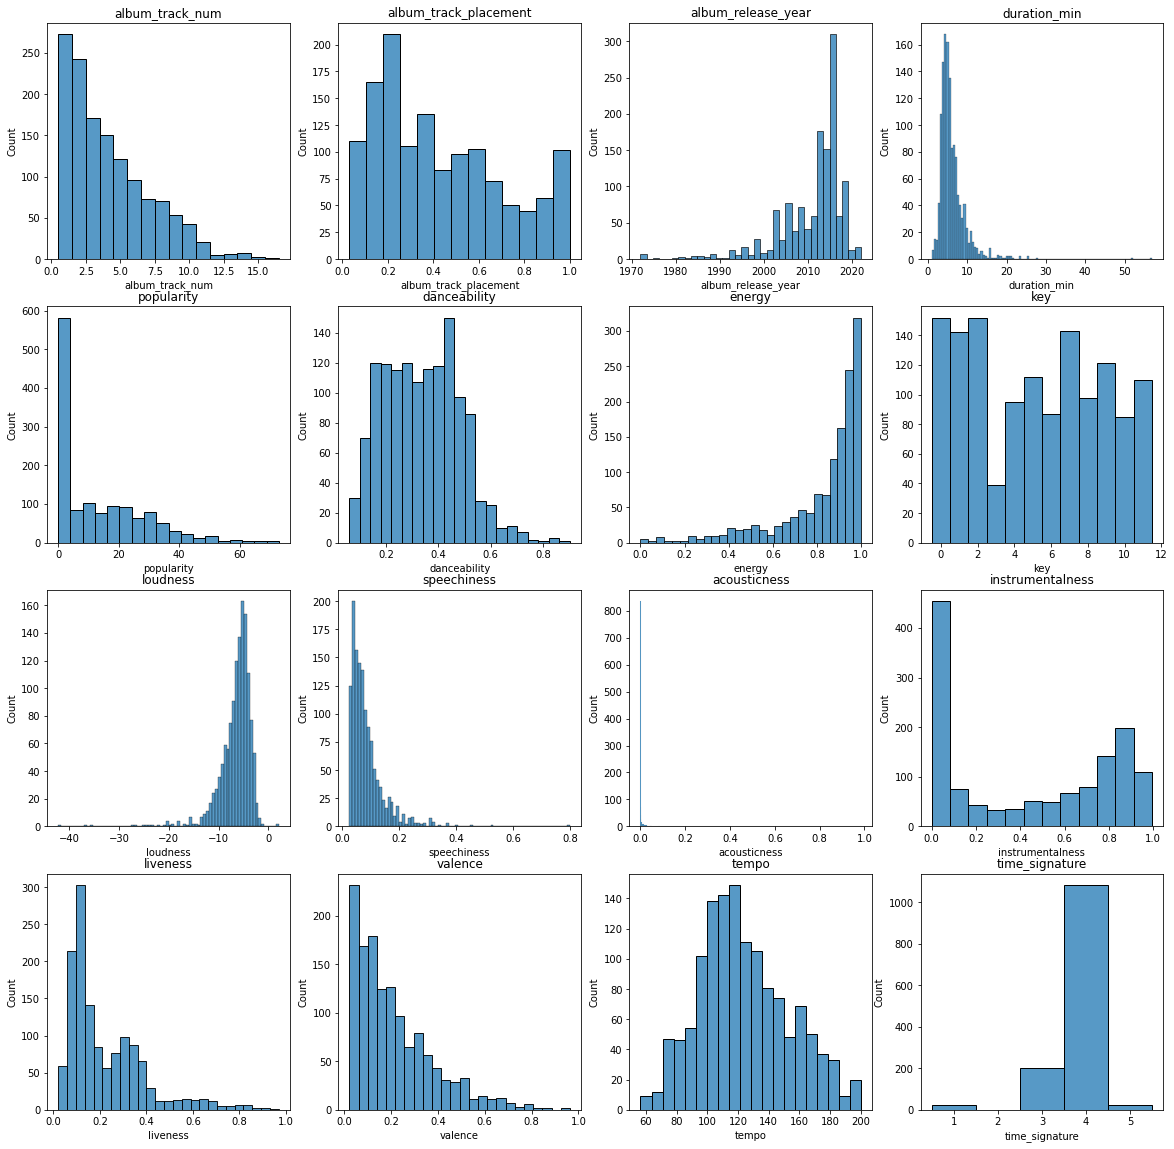

In [12]:
fig, axes = plt.subplots(4,4, figsize=(20,20))

for col, ax in zip(numerical, np.ravel(axes)):
    if col == 'album_track_num' or col == 'time_signature' or col == 'key':
        sns.histplot(data=df, x=col, discrete=True, ax=ax)
    else:
        sns.histplot(data=df, x=col, ax=ax)
    ax.set_title(col)

Ignoring suspicions about the time_signature feature, all of these are either unsurprising or at least plausible. Two standout plots are the duration and acousticness plot. The first I assume has no outliers but rather reflects the inclusion of a few doom songs that are effectively entire albums that aren't broken into tracks. The second just reflects my taste.

In [13]:
num_small_acousticness = len(df[df['acousticness'] < 0.05])
print(f'Songs with an acousticness under 0.05 account for {np.round(100*num_small_acousticness/len(df))}% of the tracks.')

Songs with an acousticness under 0.05 account for 87.0% of the tracks.


In [14]:
df[df['acousticness'] >= 0.05][song_info + ['acousticness']].head(20)

track_name                 artist  \
4    The Lady with the Golden Stockings (The Golden...                   EABS   
29                                          Impossible               Röyksopp   
30                                          The Ladder               Röyksopp   
53                                 To Bid You Farewell                  Opeth   
55                                           Suspended                  Messa   
65                                              Kasvot                  KAUAN   
76   C.O.N.F.O.R.M. (feat. Gift Of Gab, Lateef The ...              DJ Shadow   
77   Rain On Snow (feat. Inspectah Deck, Ghostface ...              DJ Shadow   
78                                    dream is destiny          No Clear Mind   
84                                    The Power Cosmiq            Cannibal Ox   
87                                 The Bray Road Beast      The Besnard Lakes   
89                                               Honey                   Moby   
96                   All the Ships Have Been Abandoned    Wreck and Reference   
98                                       Altitude Lake                  SLIFT   
110                       Silhouettes of Death's Grace  The Ruins Of Beverast   
113                                             Gemini       Boards of Canada   
114      Dead Finks Don't Talk - 2004 Digital Remaster              Brian Eno   
117                               Never Ending Circles               CHVRCHES   
120                                              Sepal               Emptyset   
121                                    End of the Line           Sleigh Bells   

                               album_name  acousticness  
4                    Discipline of Sun Ra        0.1930  
29                     Profound Mysteries        0.1060  
30                     Profound Mysteries        0.5480  
53                            Morningrise        0.4500  
55                                  Close        0.3130  
65                                  Kaiho        0.6670  
76                       Our Pathetic Age        0.1810  
77                       Our Pathetic Age        0.1660  
78                       Dream is Destiny        0.2920  
84    Blade of the Ronin (Deluxe Edition)        0.2110  
87              A Coliseum Complex Museum        0.4000  
89                   Play & Play: B Sides        0.1300  
96                         Black Cassette        0.0937  
98                                  UMMON        0.3270  
110  Please Don't Walk on the Mass Graves        0.0862  
113                    Tomorrow's Harvest        0.9820  
114               Here Come The Warm Jets        0.0560  
117      Every Open Eye (Special Edition)        0.0873  
120                                 Sepal        0.0597  
121                       Reign of Terror        0.3700

My guess here is that metal tracks are very easy to identify as not being acoustic, which is reasonable as metal almost requires distorted electric guitars. From 20 random songs with relatively high acousticness values, we see only a few tracks by metal bands, but they don't fit in the metal category. The Opeth track is mostly acoustic guitar and fretless base. The KAUAN song is essentially a post rock songs. The Ruins of Beverast song is closest to a traditional metal song, but relies heavily on clean guitars. The Messa track is the hardest to explain but is not a particularly heavy track, and has some (nearly) clean rhythm guitar work.

## Boolean Features

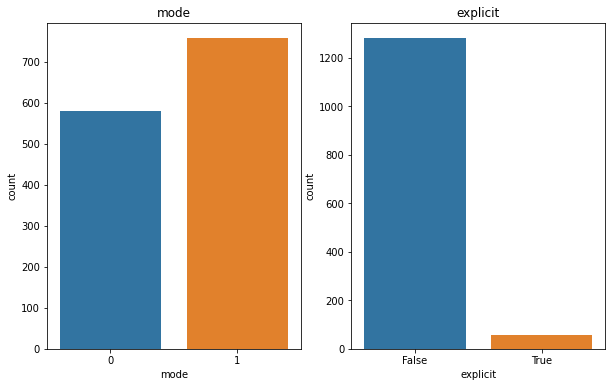

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

for col, ax in zip(boolean, axes):
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(col)

I am skeptical of both of these. The mode feature represents whether songs are major (1) or minor (0). The plot above suggests most of the songs I've liked have been major. While not impossible, I listen to a lot of metal, which makes the plot unlikely. The second plot is likely misleading. Spotify uses the False value in its explicit feature for songs if it does not know whether lyrics are explicit. Again, I listen to a good bit of metal, so it's highly likely that I've liked a lot songs with unpublished lyrics.

## Other Categorical Features

In [16]:
num_unique_bands = len(df['artist'].unique())
num_unique_albums = len(df['album_name'].unique())
print(f'There are {num_unique_albums} albums by {num_unique_bands} bands.')

There are 666 albums by 434 bands.


In [17]:
print('Top 5 most liked artists:')
df['artist'].value_counts().head(5)

Top 5 most liked artists:


Agent Fresco           23
Sonata Arctica         22
Mors Principium Est    21
Meshuggah              18
GALNERYUS              16
Name: artist, dtype: int64

In [18]:
print('Top 5 most liked albums:')
df['album_name'].value_counts().head(5)

Top 5 most liked albums:


Pariah's Child           14
Songs For The Deaf       14
Destrier                 14
The Tides of Damocles    10
Dawn of the 5TH Era       9
Name: album_name, dtype: int64

I list only the top five for each since something immediately popped out at me - the bands with songs I like most frequently and albums with songs I like most frequently are not comprised mostly of bands or albums I remember liking much, or sometimes at all. On closer inspection, what seems to have happened is that I liked entire albums, which I know is something I've done so I don't forget to get around to listening to an album. This makes it look like I like all of the tracks on the album and inflates the number of songs by the band that I've liked. Combine this with the relatively large number of unique artists and bands, and I do not think there is much useful information in these features.

Since I can confidently state I listen to mostly metal, I would hazard a guess that I listen to bands mostly from a fairly small subset of European countries. If I continue this project in the future, I may find the country of origin for bands to be a more useful feature.

# Bivariate Analysis

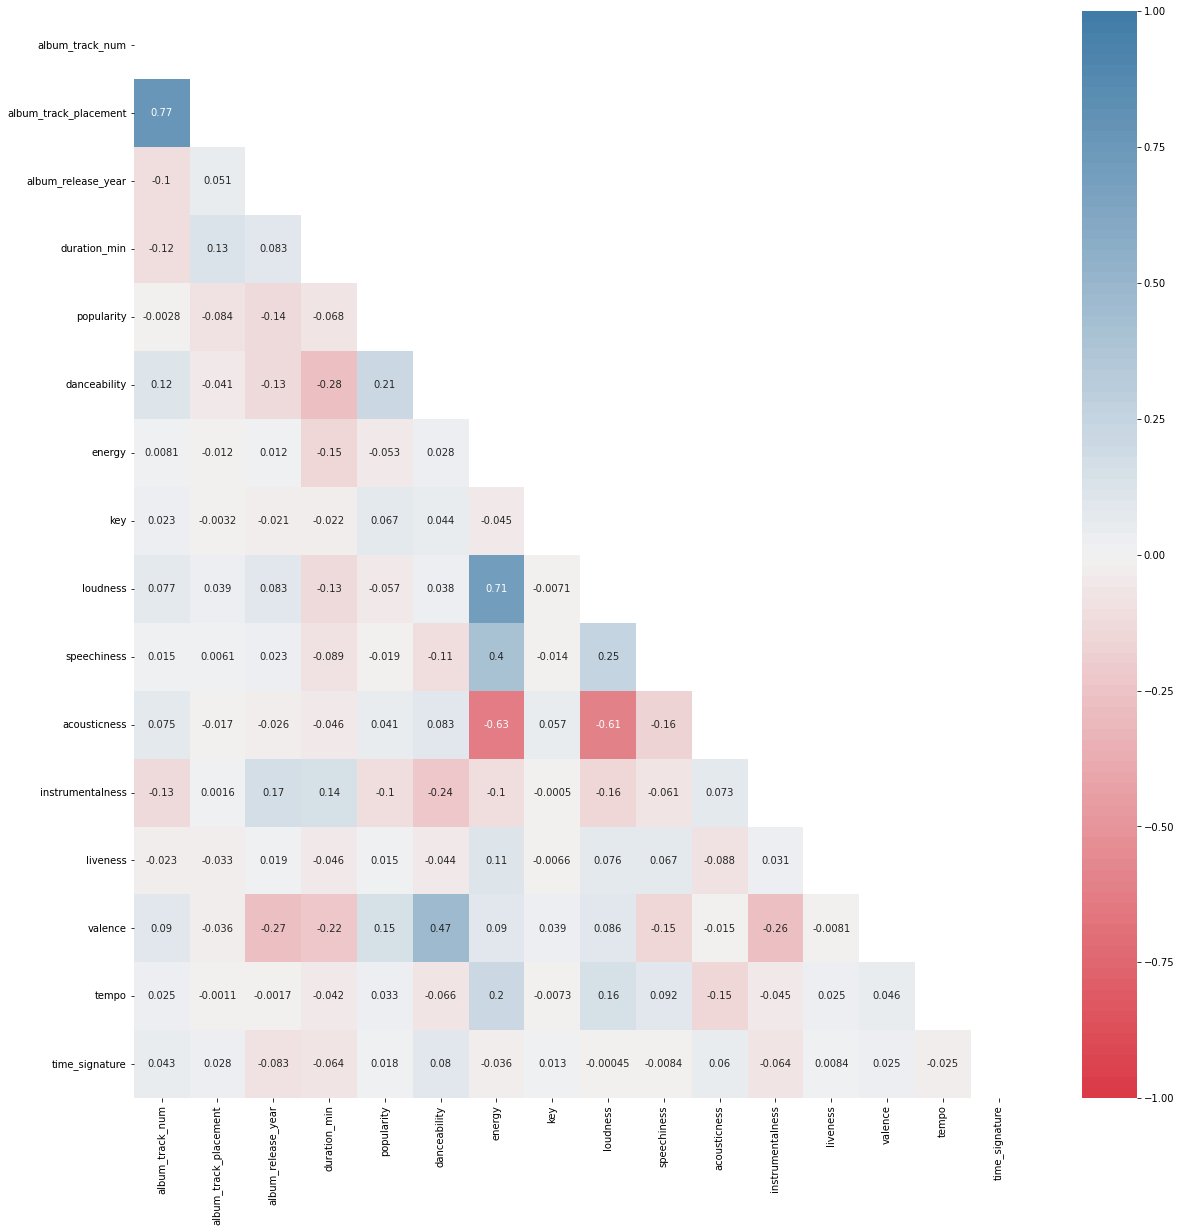

In [19]:
corr = df[numerical].corr()
mask = np.triu(corr)
cmap = sns.diverging_palette(10, 240, n=100)
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, mask=mask, cmap=cmap)
plt.show()

The strong correlations here are pretty obvious. Energy has a strong positive correlation with loudness and negative correlation with accousticness. Loudness has a strong negative correlation with accousticness. All three are fairly straightforwards. The correlation between album_track_num and album_track_placement is also trivial given how the latter is defined.

The smaller correlations between album_release_year and instrumetnalness and valence are interesting but merit careful interpretation. To oversimplify a bit, these could reflect either that if a song is released later, I will prefer it more if it is more instrumental or melodic, or it could reflect that my taste in music has led to me liking more sad and instrumental songs as time has gone on.

The correlation coefficient tracks linear relationshiips. We can see relationships between pairs of variables generally plotted below.

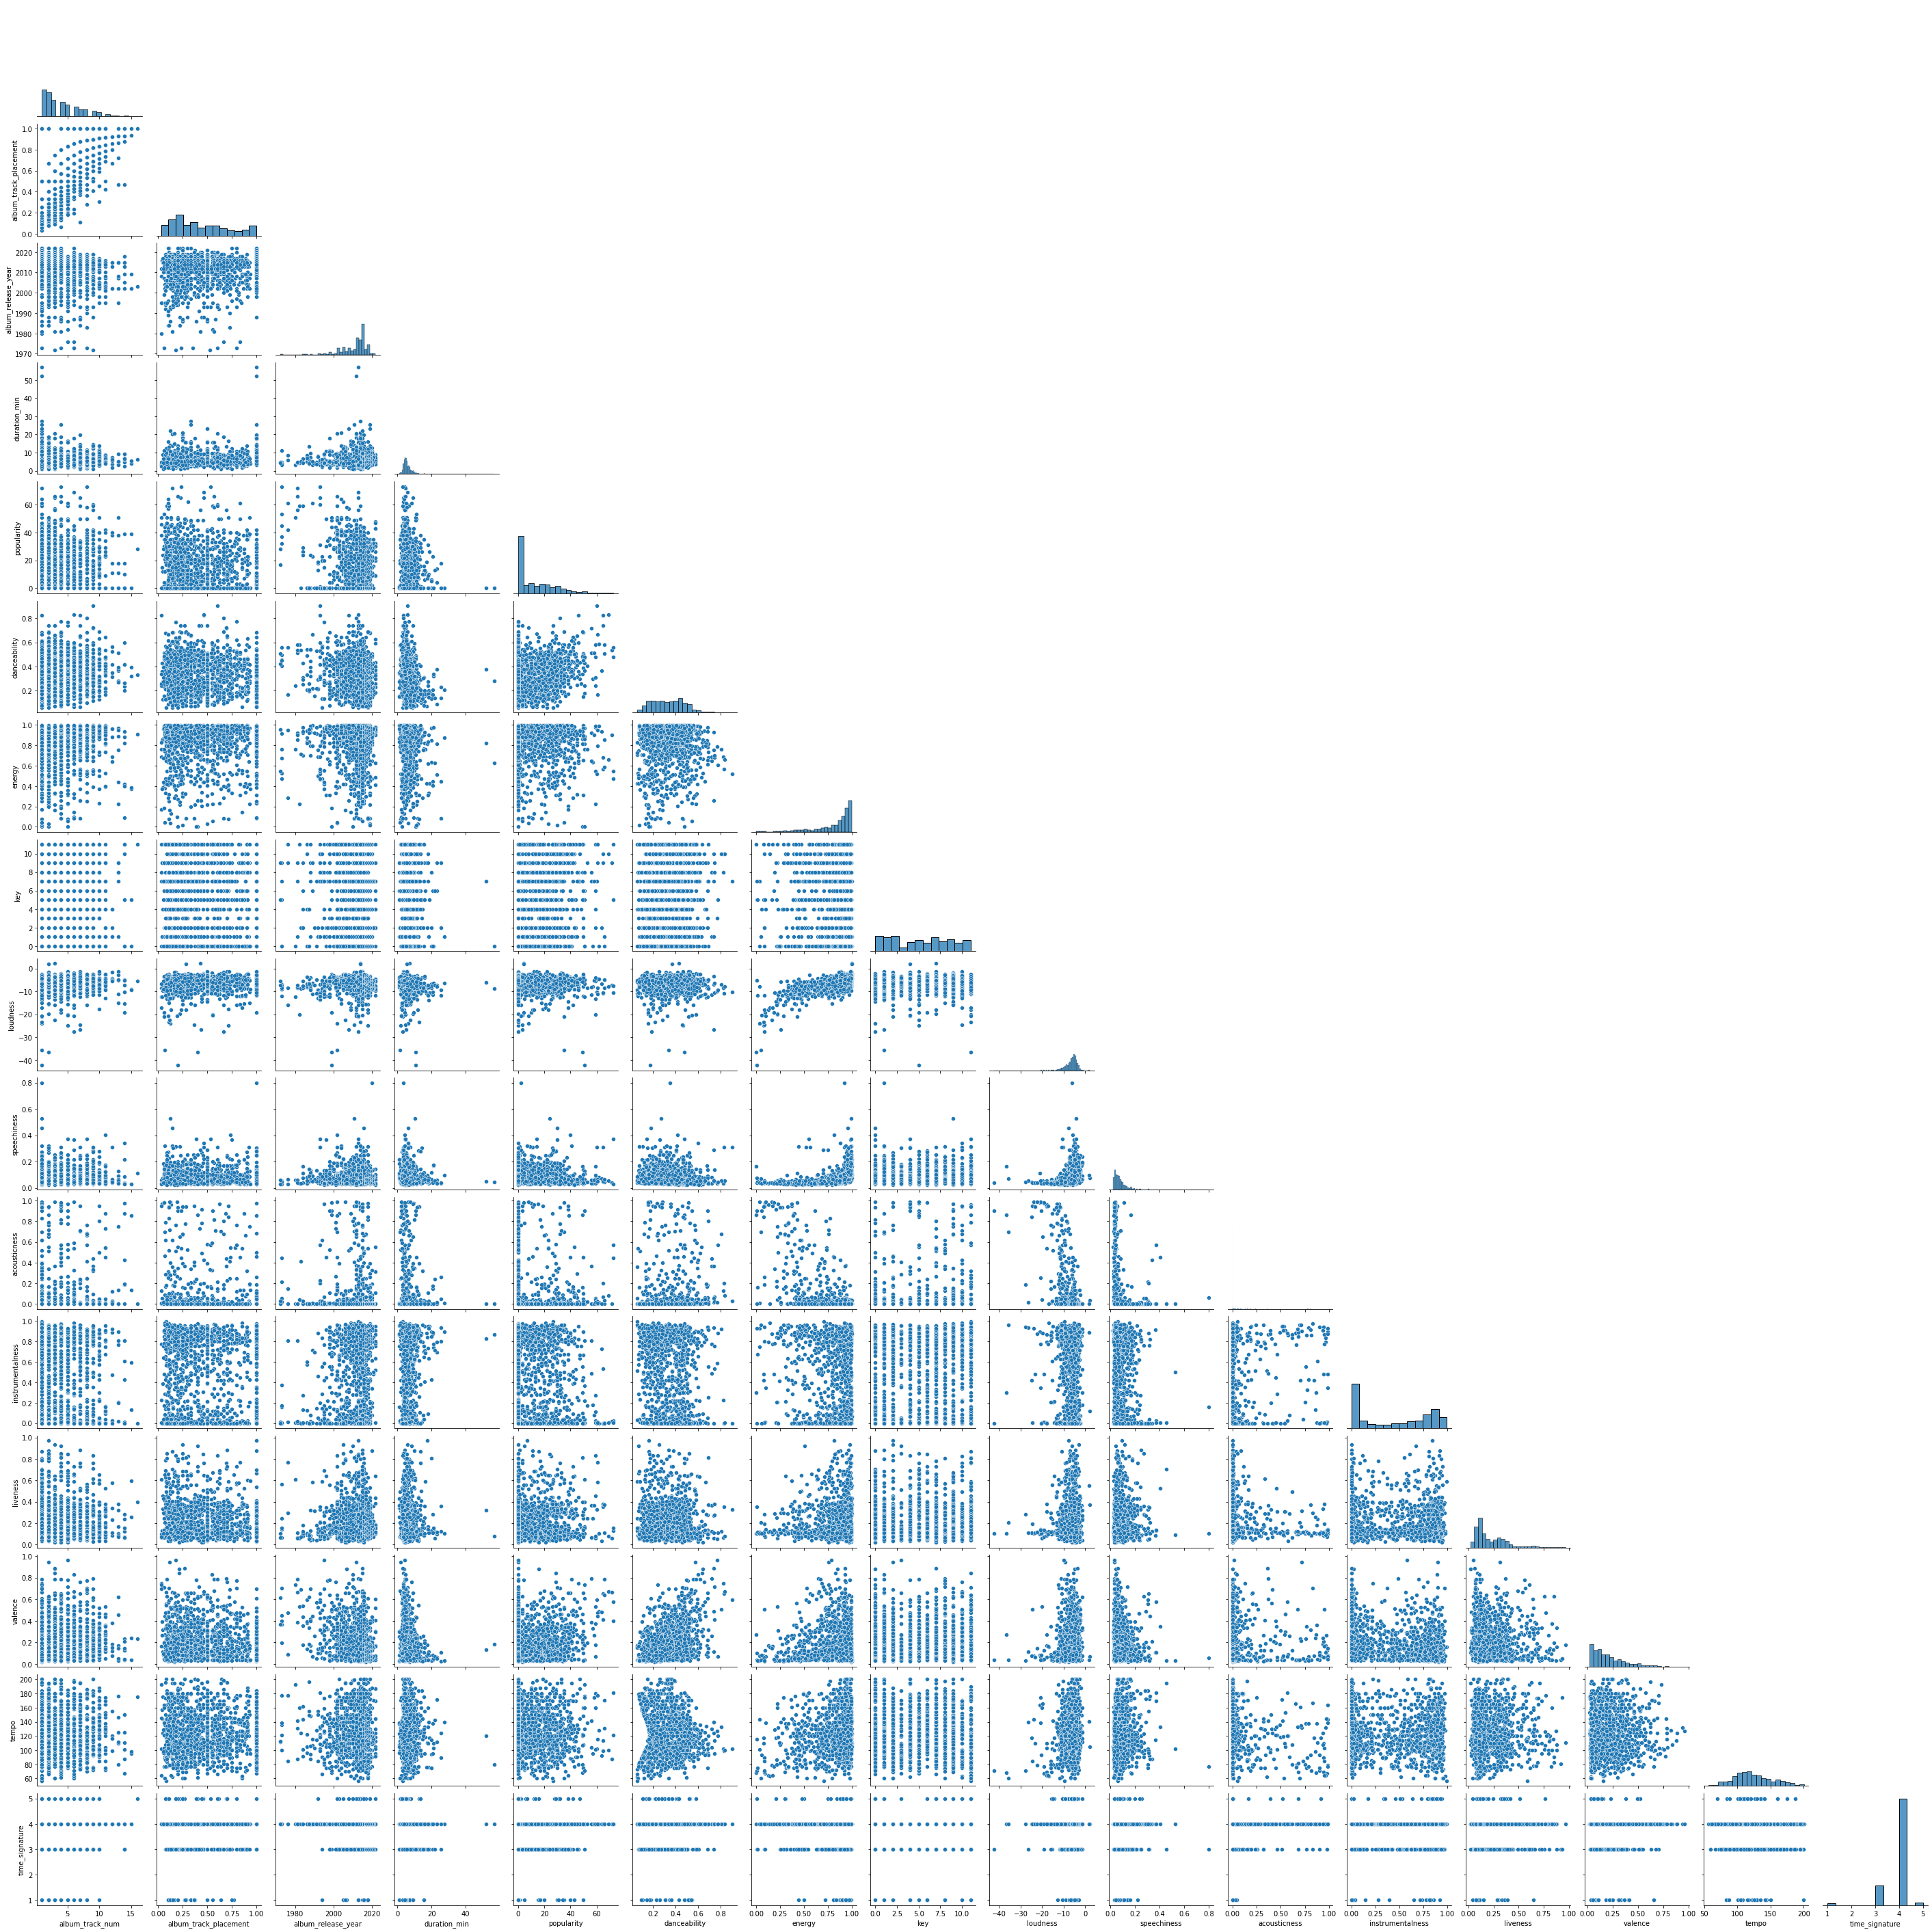

In [20]:
sns.pairplot(df[numerical], corner=True)
plt.show()

# Clustering
I want to see if I can cluster the data. I use K-Means clustering on the numerical features to achieve this. For some fixed number of clusters k, k-means begins by picking random points to be cluster centers, then assigning each point to the cluster with the nearest center. The centers of each cluster are computed, then points are reassigned to the cluster with the nearest center. This process of computing cluster centers and reassigning points repeats until some convergence condition is met, like the sum of squared distances within clusters falling below some level. 

For k-means, means and variances must be standardized. I use mean = 0 and std = 1.

K-means is unsupervised, meaning it does not use labeled data to train. This means that we cannot compare predictions to known values to choose the number of clusters k. Instead, I use the elbow method. For the elbow method, first you choose some range of k values to try. You run k-means for each and plot the sum of squared distances within clusters against the k values. Ideally, the plot should have what looks like an "elbow." For values of k larger than the value at the elbow, the sum of squard distances should decrease much more slowly than it increases for smaller values.

Despite the elbow method, my ultimate goal is for the clusters to be human interpretable. Therefore, I use the elbow method as a guideline and will deviate to the extent it benefits the interpretability of the clusters.

In [21]:
ss = StandardScaler()
df_scaled = ss.fit_transform(df[numerical])

100%|██████████| 19/19 [00:02<00:00,  9.18it/s]


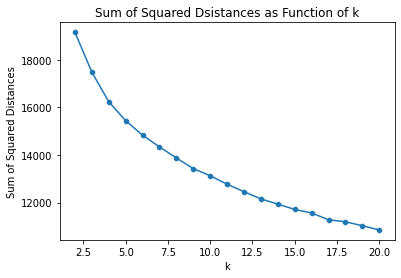

In [22]:
from sklearn.cluster import SpectralClustering
k_range = np.linspace(2, 20, num=19, dtype=int)
ssd = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(df_scaled)
    ssd.append(kmeans.inertia_)

sns.scatterplot(x=k_range, y=ssd)
sns.lineplot(x=k_range, y=ssd)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Sum of Squared Dsistances as Function of k')
plt.show()

This plot is perhaps not the most ideal. Further, the elbow here is arguably at k=4. Still, I choose k=3, since i get more interpretable results.

In [23]:
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_scaled)
cluster_labels = kmeans.labels_

# Analyzing Clusters

## Visualizing Clusters
The clusters can be visualized using a dimensional reduction technique, here, princiapl components analysis (PCA). Principal components analysis finds vectors pointing in directions of maximum variance in the data, each vector orthogonal to all the other vectors. These vectors are the principal components. To visualize the clusters, the data is plotted on the first two principal coordinates.

In [24]:
pca = PCA()
pca_vals = pca.fit_transform(df_scaled)

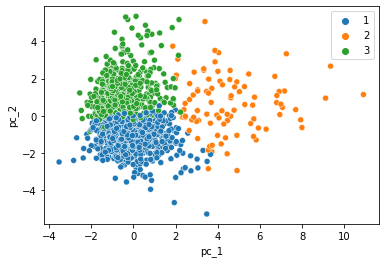

In [25]:
df_pca = pd.DataFrame(pca_vals, columns=[f'pc_{i+1}' for i in range(len(numerical))])
sns.scatterplot(data=df_pca, x='pc_1', y='pc_2', hue=cluster_labels+1, palette='tab10')
plt.show()

We can see from the above that the clusters look nicely separated when plotted on the principal coordinates. However, the third cluster seems to have fewer members than the other two.

## Summary Statistics

In [26]:
# Add cluster labels to original dataframe
df['cluster_labels'] = cluster_labels +1

I will plot the summary statistics for each feature broken out by clusters. Do do this, first I calculate the mean and standard deviation for each feature for each cluster. I also check the number of members in each cluster.

In [27]:
df_summ_stats = df[numerical + ['cluster_labels']].groupby('cluster_labels').agg(['mean', 'std', 'count'])
df_summ_stats

album_track_num                 album_track_placement  \
                          mean       std count                  mean   
cluster_labels                                                         
1                     3.001515  2.154502   660              0.383988   
2                     4.423913  3.680163    92              0.430987   
3                     5.417808  3.085976   584              0.490811   

                               album_release_year                  \
                     std count               mean       std count   
cluster_labels                                                      
1               0.264922   660        2013.086364  4.995305   660   
2               0.308284    92        2010.913043  8.058375    92   
3               0.278154   584        2008.323630  8.951157   584   

               duration_min  ... liveness   valence                  \
                       mean  ...    count      mean       std count   
cluster_labels               ...                                      
1                  7.121147  ...      660  0.128767  0.089445   660   
2                  5.981275  ...       92  0.147179  0.159595    92   
3                  5.163616  ...      584  0.314215  0.177114   584   

                     tempo                  time_signature                  
                      mean        std count           mean       std count  
cluster_labels                                                              
1               123.838286  29.351438   660       3.734848  0.606738   660  
2               106.431957  30.759783    92       3.902174  0.420878    92  
3               126.399851  28.050337   584       3.892123  0.457834   584  

[3 rows x 48 columns]

This confirms what I determined from the PCA plot - there are much fewer members in the third cluster than the other two.

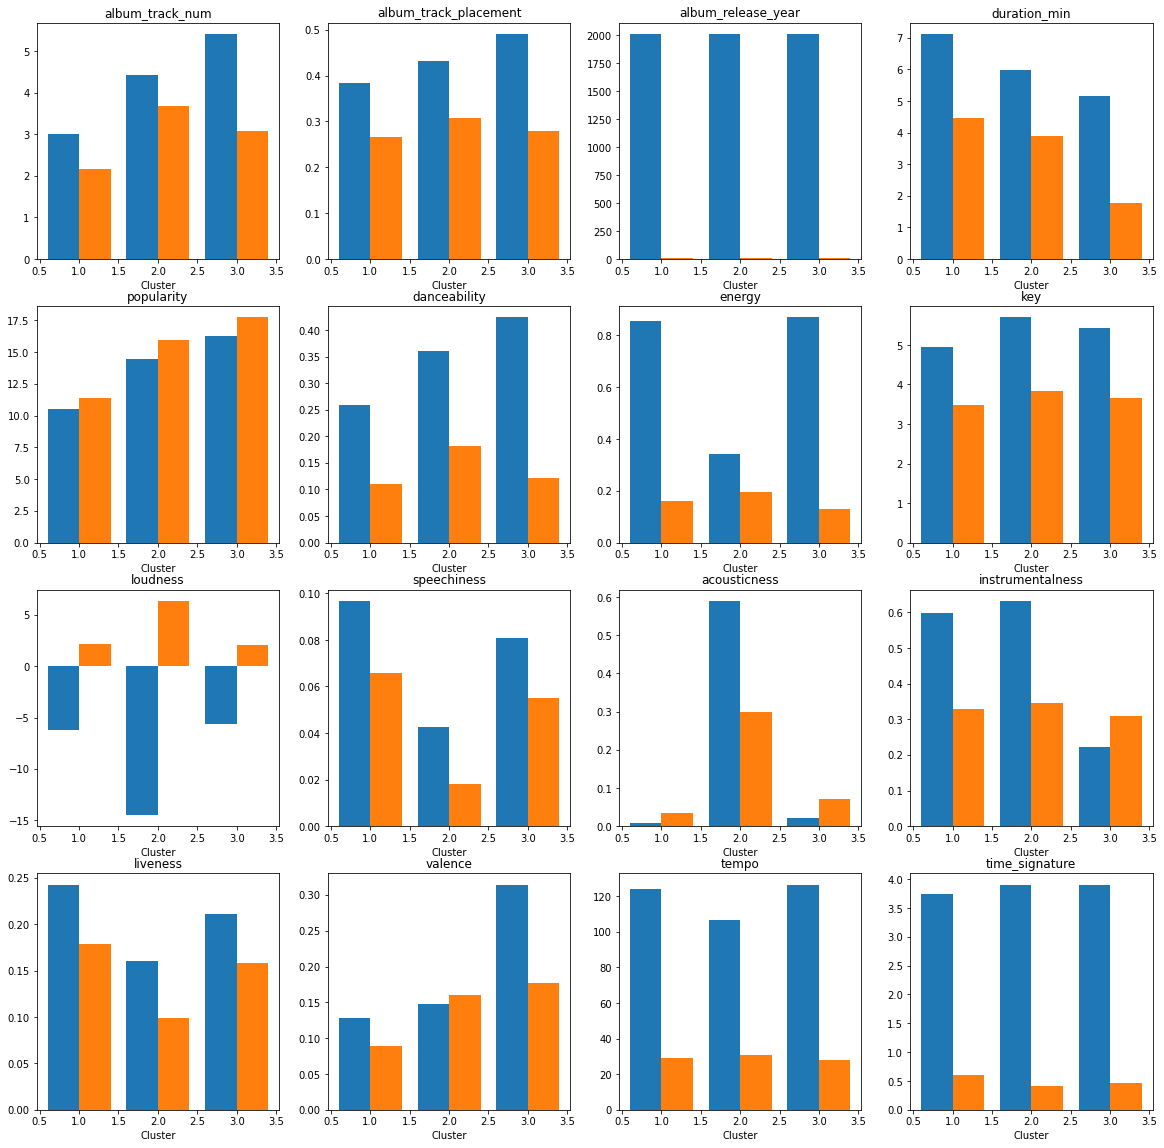

In [28]:
fig, axes = plt.subplots(4, 4, figsize=(20,20))
clusters = np.array(range(1, k+1))
for feature, ax in zip(numerical, np.ravel(axes)):
    # Plot means
    ax.bar(x=clusters - 0.2, height=df_summ_stats[feature]['mean'], width=0.4)

    # Plot standard deviations
    ax.bar(x=clusters + 0.2, height=df_summ_stats[feature]['std'], width=0.4)

    ax.set_title(feature)
    ax.set_xlabel('Cluster')

plt.show()

To avoid cluttering up the plots with legends, note that means are the bars on the left (in blue), and standard deviations are the bars on the right (in organge).

By examining the above chart - and noting we are not testing for differences between means and that we have disimilar cluster membership levels - we can see that it appears the clustering has found songs that are distinct in the distribution of their features, particularly when looking at features like danceability, speechiness or valence. Cluster 1 stands out in particular for its substantially lower loudness, speechiness and energy levels.

## Variable Distributions and Relationships Within Clusters
We can now plot similar plots to those in the initial data analysis, except this time, we can break songs out by cluster assignment.

## Univariate Distributions

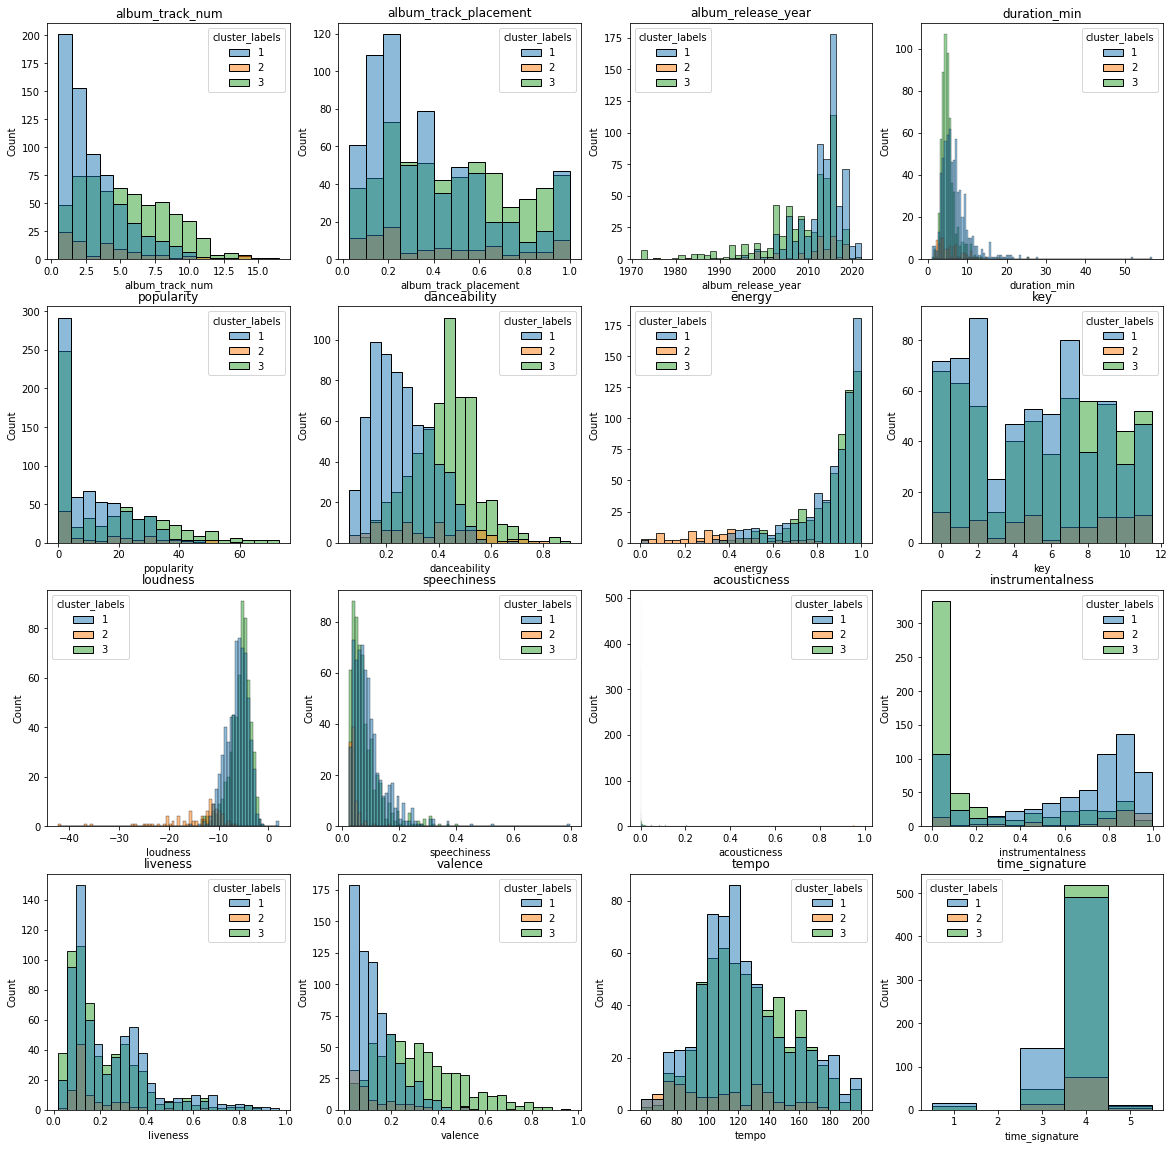

In [29]:
fig, axes = plt.subplots(4,4, figsize=(20,20))

for col, ax in zip(numerical, np.ravel(axes)):
    if col == 'album_track_num' or col == 'time_signature' or col == 'key':
        sns.histplot(data=df, x=col, hue='cluster_labels', discrete=True, ax=ax, palette='tab10')
    else:
        sns.histplot(data=df, x=col, hue='cluster_labels', ax=ax, palette='tab10')
    ax.set_title(col)

From the above, we can see that features do not only differ when looking at the mean and standard deviation, but a feature that seems to be distributed according to one type of distribution in one cluster appears to be distributed according to a different type in a different cluster. Danceability is the most obvious example of this.

## Relationships between Features Within Clusters

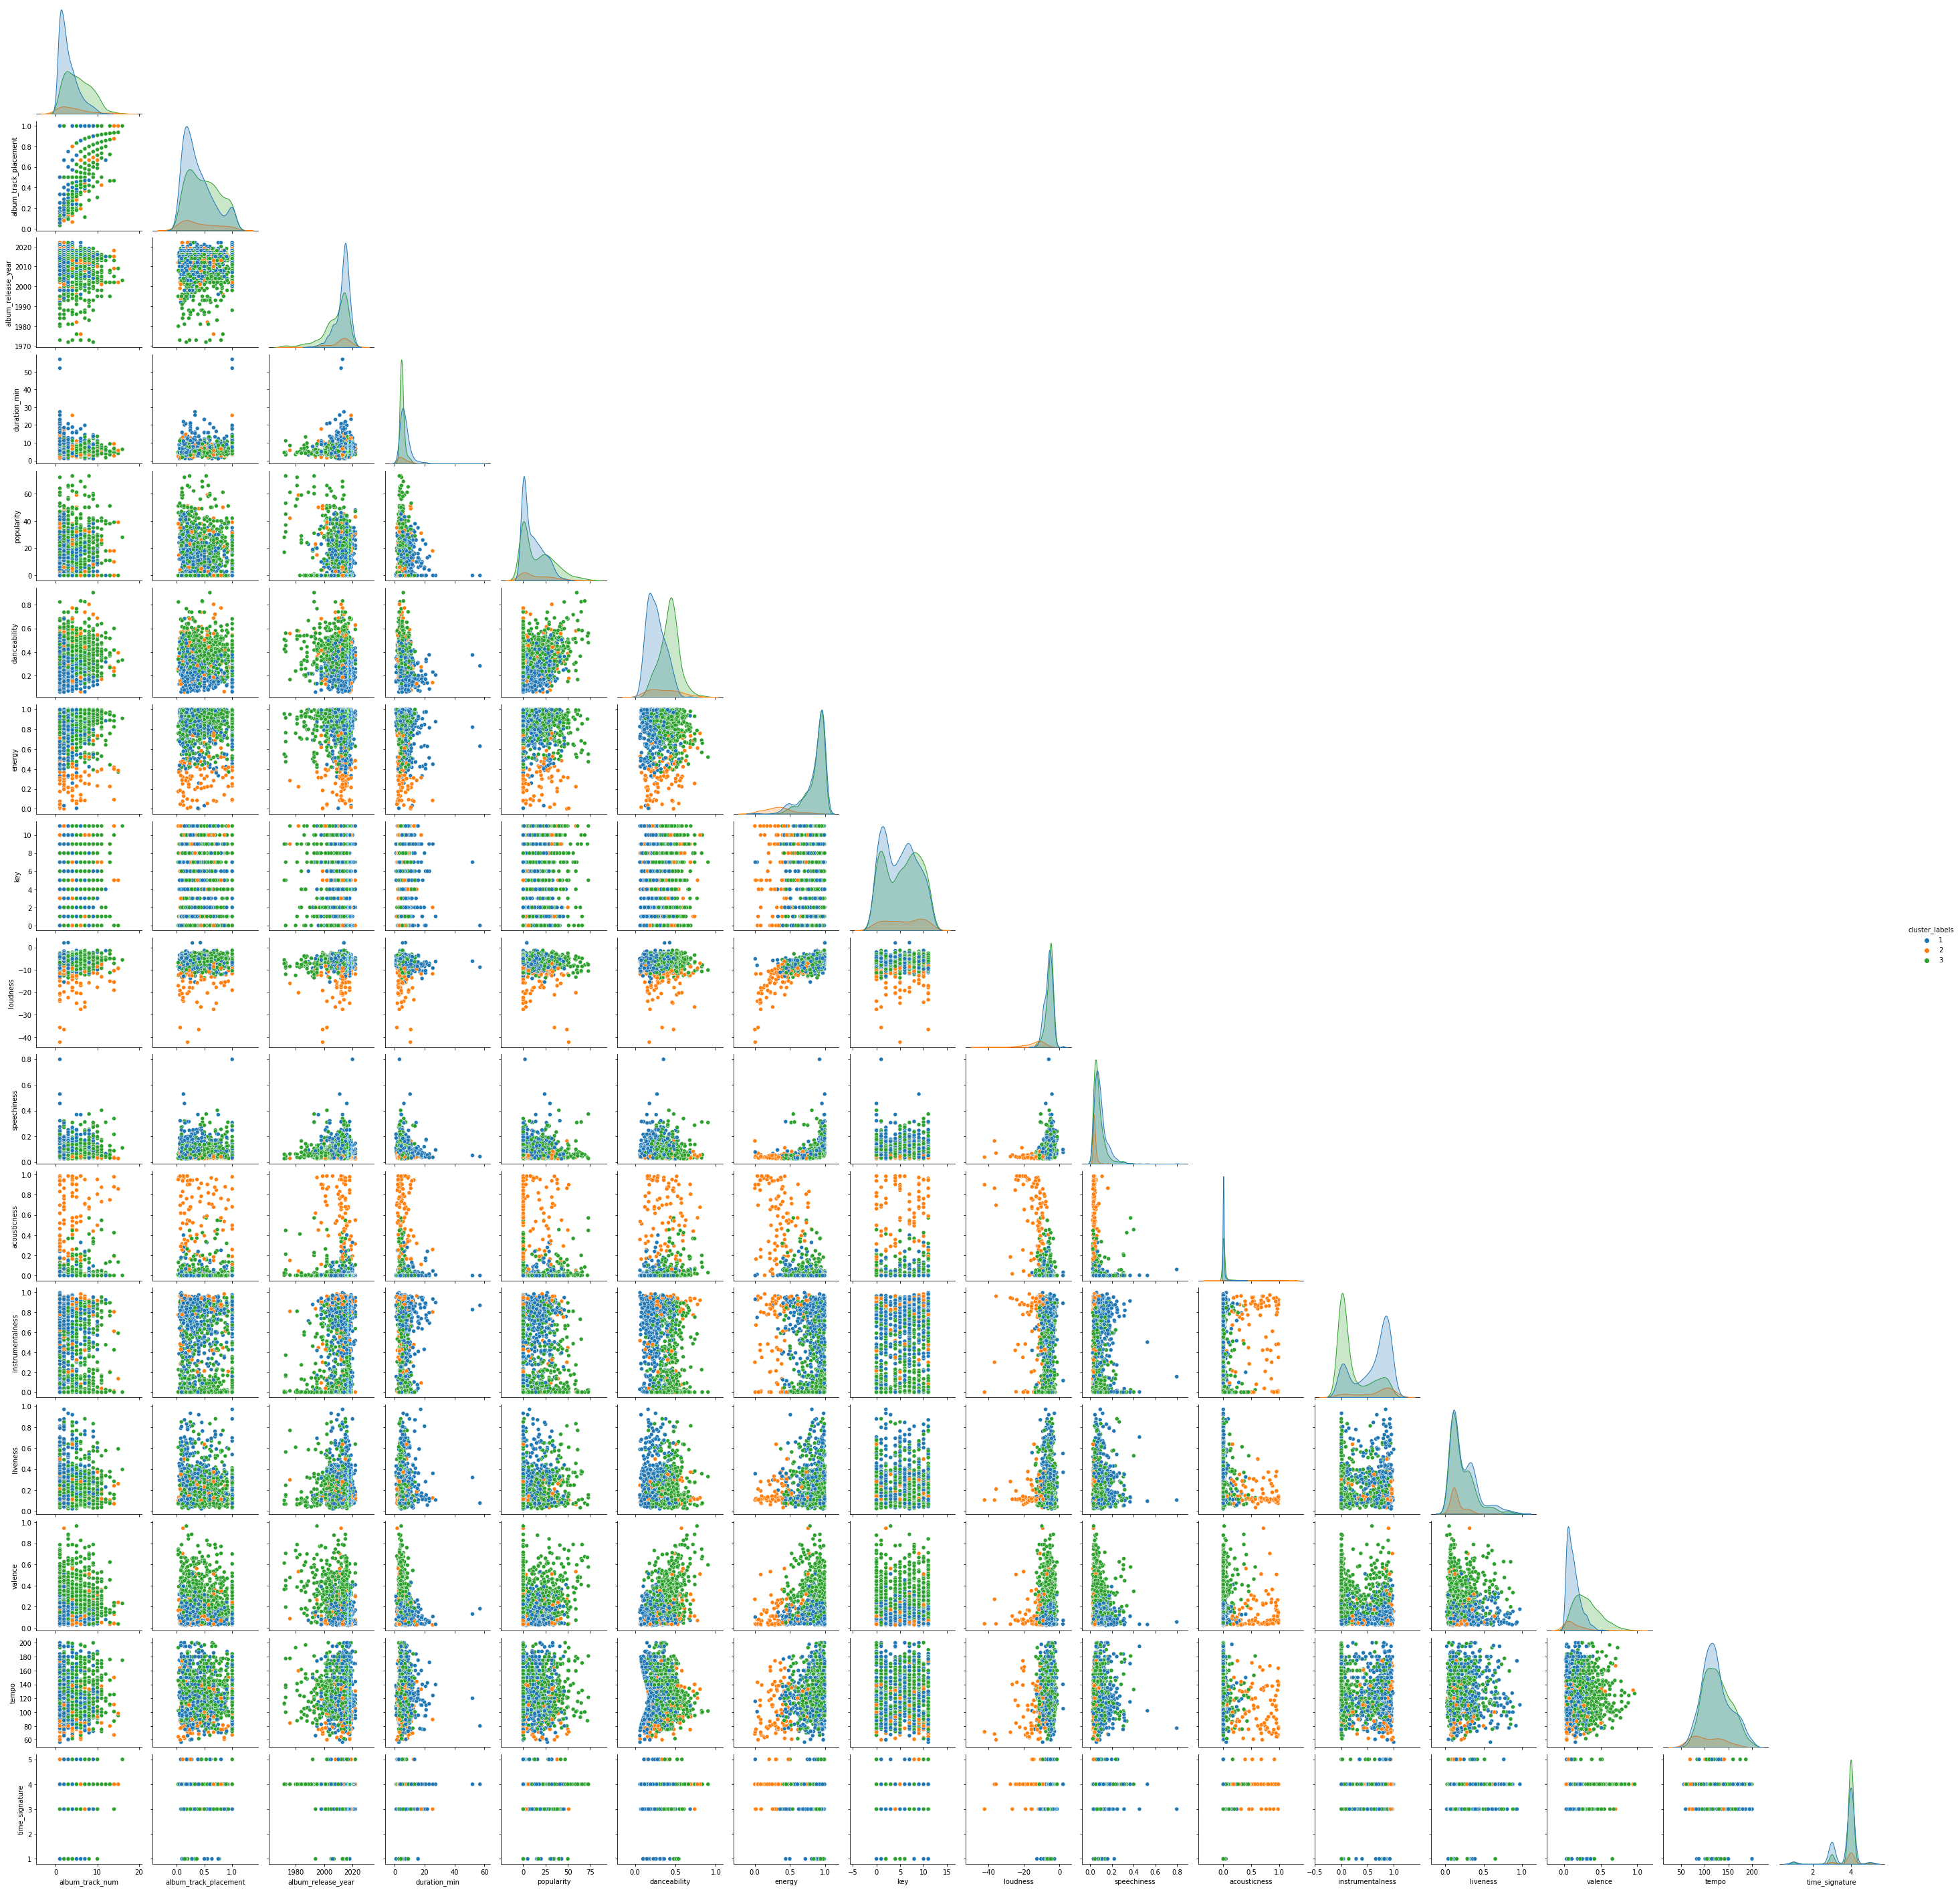

In [30]:
sns.pairplot(df[numerical + ['cluster_labels']], hue='cluster_labels', corner=True, palette='tab10')

## Examining Songs within Clusters
I print 20 songs from each cluster.

In [31]:
print('50 Random Songs from Cluster 1')
df[df['cluster_labels'] == 1][song_info].sample(frac=1, random_state=123).head(20)

50 Random Songs from Cluster 1


track_name                  artist  \
478                                Tongues of Silver              Black Fast   
586                             Leader of the Titans     Mors Principium Est   
362                         Fridom Med Daudens Klang                   Vreid   
532                                       Deadweight                   Elder   
277                  Vast Oceans Lachrymose/Epilogue       While Heaven Wept   
400   Hold Your Children Close and Pray for Oblivion          Anaal Nathrakh   
948                                   Drawn to Black               Insomnium   
63                     Descending into the Labyrinth                  Tempel   
965                                Abhorrent Paragon        Impetuous Ritual   
1090                                         Kinetic                Arcturus   
1022               Progenies of the great apocalypse            Dimmu Borgir   
12                                The Mold Testament       Inhuman Condition   
406                              Acheronta Movebimus          Anaal Nathrakh   
472                             Not Unlike The Waves                Agalloch   
194                                      Eiswanderer  Der Weg einer Freiheit   
439                                   An Ember's Arc                Be'lakor   
1153                            Cold Hate Warm Blood               Cryptopsy   
979                                      Blood Libel                  Saille   
125                                  Angelus Noctium              Gatekeeper   
527                                        Dimmalimm                   DIMMA   

                                           album_name  
478                                Terms of Surrender  
586                               Dawn of the 5TH Era  
362                                           Sólverv  
532                                              Lore  
277                            Vast Oceans Lachrymose  
400                              The Whole of the Law  
948                           Above the Weeping World  
63                              The Moon Lit Our Path  
965   Unholy Congregation of Hypocritical Ambivalence  
1090                                 The Sham Mirrors  
1022                            Death Cult Armageddon  
12                                           Fearsick  
406                                       Desideratum  
472                           Ashes Against The Grain  
194                                           Stellar  
439                                           Vessels  
1153                                Whisper Supremacy  
979                                              Ritu  
125                                         Vigilance  
527                                        Myrkraverk

I find this cluster particularly impressive. It's pretty clearly identified slower, quieter, dronier tracks with a large portion of the songs listed above being non-metal tracks.

In [32]:
print('50 Random Songs from Cluster 2')
df[df['cluster_labels'] == 2][song_info].sample(frac=1, random_state=123).head(20)

50 Random Songs from Cluster 2


track_name  \
1105  Symphony No. 9 in E Minor "From The New World"...   
1052                                             Origin   
346                                        Death Rattle   
819                                 Daughter of the Sea   
1273                                           Fragment   
65                                               Kasvot   
394                                               Zebra   
1221                                               Open   
1226                                                III   
1100                                      Voie Maritime   
470                                              Kasvot   
817                                             Jealous   
157                                           Für Alina   
1054                                         Arcenstone   
1292                                    Binker Part Two   
493                          Blaise Bailey Finnegan III   
343                                Let Fall the Curtain   
1137                                      Mosquito Song   
816                                             Ageless   
576               Miserere in C Minor Psalm 50, ZWV. 57   

                           artist                               album_name  
1105               Antonín Dvořák                František Stupka conducts  
1052             Keep Of Kalessin                                 Kolossus  
346                  Agent Fresco                                 Destrier  
819               House of Wolves                      Daughter of the Sea  
1273                     Emptyset                                    Recur  
65                          KAUAN                                    Kaiho  
394         Oneohtrix Point Never                             R Plus Seven  
1221                   Com Truise                                 In Decay  
1226                        KAUAN                                    Pirut  
1100                       Ô Paon                                   Fleuve  
470                         KAUAN                                    Kaiho  
817               House of Wolves                         Fold in the Wind  
157                     Arvo Pärt                         Arvo Pärt: Alina  
1054                    Summoning                               Lost Tales  
1292                   LAKE R▲DIO        Planet Earth About To Be Recycled  
493   Godspeed You! Black Emperor            Slow Riot for New Zero Kanada  
343                  Agent Fresco                                 Destrier  
1137      Queens of the Stone Age                       Songs For The Deaf  
816               House of Wolves                         Fold in the Wind  
576            Jan Dismas Zelenka  Zelenka: De Profundis, Misere & Requiem

In [33]:
print('50 Random Songs from Cluster 3')
df[df['cluster_labels'] == 3][song_info].sample(frac=1, random_state=123).head(20)

50 Random Songs from Cluster 3


track_name               artist  \
696                                      Twisted Eyes            Persuader   
214                                    Far from Light           Procession   
1203                               Last Day In Heaven            Barathrum   
553                                         Affection      Crystal Castles   
1121                                  Daylight Misery            Draconian   
843                       Creeping Death (Remastered)            Metallica   
122                                   The Astral Seer               Hällas   
751        Only the Broken Hearts (Make You Beatiful)       Sonata Arctica   
879                                  Source of Icon O               Origin   
1291                            Fight for Deliverance             Heavenly   
228                                     Judgement Day                ANGRA   
697                                   End of Our Rope      Nocturnal Rites   
766                                           Redline            Lazerhawk   
1158                             Breathing Pestilence         Misery Index   
1082                                            Takao             CHTHONIC   
577                               Apprentice of Death  Mors Principium Est   
787                                         Limelight                 Rush   
933                             Temple of the Art-God                Gorod   
534                                   Souls Of Skylon              Gemanon   
1122  Everything I Touch Turns To Gold (Then To Coal)       Woods Of Ypres   

                                album_name  
696                        When Eden Burns  
214                  To Reap Heavens Apart  
1203                    Legions of Perkele  
553                                  (III)  
1121                      Arcane Rain Fell  
843   Ride The Lightning (Deluxe Remaster)  
122            Excerpts from a Future Past  
751                   Stones Grow Her Name  
879                            Omnipresent  
1291                          Dust to Dust  
228                                Rebirth  
697                         Grand Illusion  
766                                Redline  
1158                             Discordia  
1082                         Takasago Army  
577                Embers of a Dying World  
787        Moving Pictures (2011 Remaster)  
933              A Maze of Recycled Creeds  
534                                GEMANON  
1122              Woods 4: The Green Album

### Artists and Albums Unique to One Cluster
Useful to interpreting the clusters will be to find the artists and albums that are in one cluster but not the other cluster. I find these and print them out. Rather than printing all of the values unique to a cluster, I print the minimum of fifty and the total number of artists/albums in the cluster to save space. However, I did personally examine all of the values unique to each cluster.

#### Artists only Found Within one Cluster

In [34]:
def unique_to_cluster(feature):
    unique_labels  = df['cluster_labels'].unique()
    unique_feature_vals = {cluster:[] for cluster in unique_labels}

    for cluster in unique_labels:
        other_clusters = [i for i in unique_labels if i != cluster]
        unique_values = df[df['cluster_labels'] == cluster][feature].unique()

        # Find unique values in other clusters
        other_cluster_values = []
        for i in other_clusters:
            other_cluster_values.extend(df[df['cluster_labels'] == i][feature].unique())

        # Find values unique to cluster under consideration
        for value in unique_values:
            if value not in other_cluster_values:
                unique_feature_vals[cluster].append(value)
    return unique_feature_vals

no_overlap_artists = unique_to_cluster('artist')
for cluster in clusters:
    num_unique_to_cluster = len(no_overlap_artists[cluster])
    print(f'The following {min(50, len(no_overlap_artists[cluster]))} artists are only in cluster {cluster}:')
    print(', '.join(no_overlap_artists[cluster][:min(50, len(no_overlap_artists[cluster]))]))

The following 50 artists are only in cluster 1:
Nite, Artificial Brain, Sulphur Aeon, Thrawsunblat, Latitudes, Cities of the Plain, Generation Of Vipers, Tempel, Inhuman Condition, Pan-Amerikan Native Front, Blackbraid, Mithras, Vanum, Barishi, Be'lakor, Mesarthim, Mistur, Internal Bleeding, Garden Of Shadows, Cloudkicker, Heretoir, The Besnard Lakes, Der Weg einer Freiheit, Wreck and Reference, Dumal, SLIFT, Nocturnal Graves, Haunted Shores, Fluisteraars, Eneferens, Hope Drone, ORM, Sarastus, Gatekeeper, Imha Tarikat, Pestilence, Vukari, Consummation, Chthe'ilist, False, Monolithe, Void Omnia, Solar Temple, Windswept, Krater, Mizmor, Nullingroots, Djevel, Noctem, Nightfell
The following 23 artists are only in cluster 2:
No Clear Mind, Boards of Canada, ROSK, Arvo Pärt, Nils Frahm, Joe Jackson, Arnold Schoenberg, Kayako Bruckmann, Countless Skies, The Red Army Choir, Jan Dismas Zelenka, House of Wolves, The Howling Void, Duster, Vangelis, Ludwig van Beethoven, Ô Paon, Antonín Dvořák, G

#### Artists only Found Within one Cluster

In [35]:
no_overlap_album = unique_to_cluster('album_name')
for cluster in clusters:
    num_unique_to_cluster = len(no_overlap_album[cluster])
    print(f'The following {min(50, len(no_overlap_artists[cluster]))} albums are only in cluster {cluster}:')
    print(', '.join(no_overlap_album[cluster][:min(50, len(no_overlap_artists[cluster]))]))

The following 50 albums are only in cluster 1:
Voices of the Kronian Moon, Artificial Brain, The Scythe of Cosmic Chaos, Metachthonia, Old Sunlight, Where Our Homes Used to Be, Coffin Wisdom, On the Steps of the Temple, Fearsick, UNDER THE FORCE OF COURAGE, Little Turtle's War, Barefoot Ghost Dance on Blood Soaked Soil, Across The Dark, On Strange Loops, Blood from the Lion's Mouth, Viperous, Infrared Horizon, When A Shadow Is Forced Into The Light, Coherence, Argent Moon - EP, The Density Parameter, The Moon Lit Our Path, In Memoriam, Overthrow Creation, Oracle Moon, Winter's Gate, The Conjurer, Beacons, The Circle, Móðurástin, The Sanguinary Impetus, A Coliseum Complex Museum, Reflections of a Floating World, Renihilation, Sagor, Stellar, Finisterre, Black Cassette, The Lesser God, UMMON, Propelled Into Sacrilege, …from the Bloodline of Cain, Please Don't Walk on the Mass Graves, Viscera, Vlek, The Bleakness of Our Constant, Cloak of Ash, Sepal, Ir, II-Toinen Tuleminen
The following 

## Interpretation
I believe that the clusters are human interpretable.

The first category consists of less heavy or atmospheric music. Here you have classical, ambient, and acoustic music.

The second cluster consists of the heavier, darker, or more aggressive music. In this cluster, you have the more brutal death metal, the more aggresive black metal and the darker doom. The category is not perfect, as it also contains bands like The Besnard Lakes, a shoegaze band that makes fairly bright music.

The third cluster consists of more melodic, upbeat music. Here you have power metal and melodic death metal, both generally upbeat or at least melodic genres, along with catchier, non-metal artists like Daft Punk and iamamiwhoami. 

# Predictive Analysis
I would like be able to predict why I added new songs to my liked songs playlist. To do this, I train a classifier and adopt a simple anomaly detection method.

## Classifier
I train a support vector machine with a linear kernel to classify songs. The rationale for this is simple. Support vector machines classify points by where they lie with respect to a separating plane. Just looking at the plot of the clusters on the principal components, it would appear that you could draw straight lines on the plot and successfully divide most of the points into their respective clusters. Considering that more principal components will account for more information in the dataset, it is reasonable to conclude that linear hyperplanes in several dimensions will divide up the clusteres even better than straight lines in two dimensions.

In [293]:
X = df_pca
y = df['cluster_labels']

# Create training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.33, stratify=y)

In [294]:
svc = SVC(probability=True,random_state=123, kernel='linear')

svc.fit(x_train, y_train)

test_acc = svc.score(x_test, y_test)

train_acc = svc.score(x_train, y_train)

print(f'The model classified {np.round(100*train_acc, decimals=2)}% in the training set.')
print(f'The model classified {np.round(100*test_acc, decimals=2)}% in the test set.')

The model classified 99.55% in the training set.
The model classified 98.41% in the test set.


The model has good accuracy on the test set and has not overfit. However, one of the clusters is very small relative to the other two, so poor performance on that cluster will not significantly harm to accuracy. To check the performance on this cluster, I check the precision and recall on each class.

In [314]:
y_pred = svc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       218
           2       0.97      0.97      0.97        30
           3       0.98      0.98      0.98       193

    accuracy                           0.98       441
   macro avg       0.98      0.98      0.98       441
weighted avg       0.98      0.98      0.98       441



From the above, we can see that the performancee all of the classes is very good.

In [315]:
sigmoid_pred = svc.predict_proba(x_test).argmax(axis=1)
print(classification_report(y_test, sigmoid_pred+1))

              precision    recall  f1-score   support

           1       0.98      0.99      0.98       218
           2       1.00      0.93      0.97        30
           3       0.98      0.98      0.98       193

    accuracy                           0.98       441
   macro avg       0.99      0.97      0.98       441
weighted avg       0.98      0.98      0.98       441



In [321]:
mismatched_preds = [i for i, pred in enumerate(sigmoid_pred+1) if pred != y_pred[i]]
y_pred[mismatched_preds]

array([2, 2, 3])

## Anomaly Detection
I would like to be told if the model is unsure how to classify a song it is given as input. To do so, I look at the confidence the model has that a song is a member of the class the model assigns to the point. If it is below some threshold, I consider it an anomaly.

# Conclusion
This analysis more or less confirmed my suspicion. Most of the music I listen to is, in fact, corny, aggressive, and loud. However, some of the music I listen to is a bit more atmospheric.